# Clustering

I'm interested in this because we want to find galaxy clusters in DESI data. This isn't something where the traditinal CS algorithms are going to be that useful. However, it's probably worth knowing what is out there. What will be more useful is understanding what people use to compare cluster finders.

## Imports etc...

In [27]:
import numpy as np
import sklearn
import sklearn.cluster
import matplotlib.pyplot as plt
import matplotlib as mpl
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Basic Theory

We start with some data. Our goal is to partition these data points into clusters. We may or may not know how many clusters there are. 

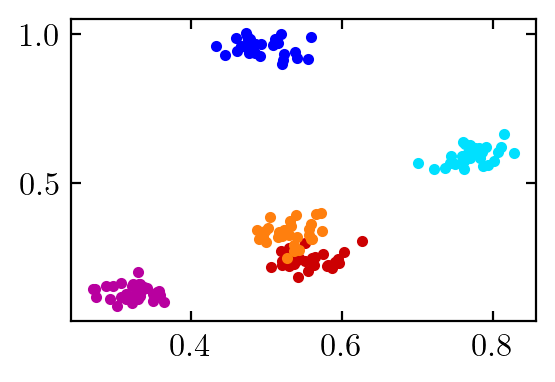

In [36]:
data = np.empty((0, 2))
n_groups, n_per_group, scatter = 5, 30, 0.03

_, ax = plt.subplots(figsize=mpl.small_plotsize)

for group in range(n_groups):
    x, y = np.random.random(size=2)
    d = (x, y) + np.random.normal(0, scatter, size=(n_per_group, 2))
    ax.scatter(d[:,0], d[:,1])
    data = np.append(data, d, axis=0)

One of the simplest ways to do this is using k-means. This requires knowing the number of clusters.

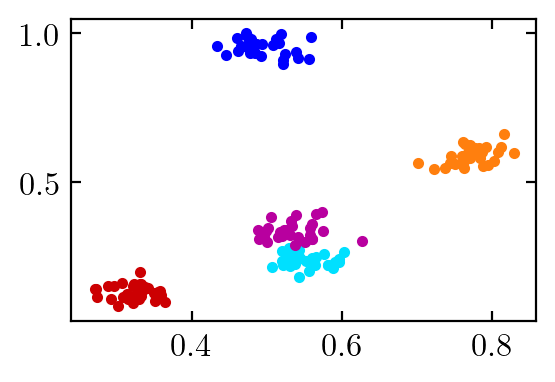

In [39]:
cluster_num = sklearn.cluster.KMeans(n_clusters=n_groups).fit_predict(data)

_, ax = plt.subplots(figsize=mpl.small_plotsize)

for i in range(n_groups):
    d = data[cluster_num == i]
    ax.scatter(d[:,0], d[:,1])

but great! We are done. This is easy! Well, actually no... This example was pretty simple. Things get more complicated when the data is not so clearly separated.

# Algorithms

See https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods

# Performance Evaluation

Let's say you run two cluster finders (A, B) on your data. How do you decide which is better? How do you decide how similar their results are?

## Really stupid idea

You could just compare the cluster labels. Find cluster 1 in A (assuming there is some deterministic way that clusters are numbered, e.g. numbers increase as the centroid moves to higher X) and give yourself a point for every object that is in cluster 1 in B. Divide by the total number of objects to get a percentage.

I did this and it is very stupid. Lets say the A and B agree exactly on all clusters except the first, where A has it as a single cluster and B splits it into two. This method then thinks that they differ in everything after this!

This is why we read the literature... To find things that work.

## [Contingency Tables](https://en.wikipedia.org/wiki/Contingency_table) and some Formalism

Basically what we have is: $N$ data points with two ways to partition them. By partition we mean that each data point is assigned a cluster from the set $A = \{a_i | i = 1,...,n\}$ and $B = \{b_i | i = 1,...,m\}$. If one of these partitions is the ground truth, we generally refer to its "clusters" as "classes". So a cluster finder tries to reproduce the ground truth classes.

We define the contingency table $C$ such that $C = \{c_{ij}\}$ where $c_{ij}$ is the number of data points that are in cluster $a_i$ and $b_j$.

A trivial example. Let's say we have 6 data points and we run our two cluster finders. The labels we get back are:
* $A = {1, 1, 3, 2, 3, 2}$
* $B = {2, 2, 1, 3, 1, 3}$

First, note that these agree. They just have slightly different labels. The contingency table looks like,

| _ | B1 | B2 | B3 |  Sum |
|---|---|---|---|---|
| A1 | 0 | 2 | 0 | 2 |
| A2 | 0 | 0 | 2 | 2 |
| A3 | 2 | 0 | 0 | 2 |
| Sum | 2 | 2 | 2 | _ |


## [Homogeneity, completeness and V-measure](https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure)

If our cluster finder is trying to reproduce ground truth classes there are a couple of intuitive properties (homogeneity, completeness) that it should fulfill. These can be combinded into an overall "validity measure".

See also:
* [the V-measure paper](https://www.aclweb.org/anthology/D07-1043)

**Homogeneity**
A cluster finder satisfies homogeneity, if all of its clusters contain data points which are members of a single class.

**Completeness**
A cluster finder satisfies completeness, if all the data points that are members of the same class are assigned to the same cluster.

Let's think up two degenerate clustering solutions:
* Assign each point to its own cluster: 100% for homogeneity, as each cluster does only have member(s) of a single class. 0% for completeness as we have probably split classes into many clusters.
* Assign every point to the same cluster: 0% for homogeneity, as the one cluster contains all classes. 100% for completeness as all the data points from each class are in the same cluster.

The math to define exactly how these properties are evaluated is a bit complicated. I might come back to it later.

V-measure gives a weighted combination of these two metrics.

## [Fowlkes-Mallows](https://scikit-learn.org/stable/modules/clustering.html#fowlkes-mallows-scores)

## [Adjusted Rand index](https://en.wikipedia.org/wiki/Rand_index)

See also: 
* https://davetang.org/muse/2017/09/21/the-rand-index/ and https://davetang.org/muse/2017/09/21/adjusted-rand-index/

Similar cluster finders should agree on which objects are in the same cluster. We don't really care what the numeric label of the cluster is. Let's define:

* $a$: the number of pairs that both A and B think are in the same cluster
* $b$: the number of pairs that both A and B think are in different clusters
* $n_{\rm pairs}$: the number of unordered pairs, ${n \choose 2} = n (n-1) / 2$

Then 
$$
RI = \frac{a + b}{n_{\rm pairs}}
$$
which is basically just the fraction of pairs that the cluster finders agree on.

Let's do a manual example. We have 4 objects. A -> [1, 1, 2, 3] B -> [1, 1, 1, 2]. $a = 1, b = 3$ (and for completeness there are 2 disagreements). Therefore, $RI = 4 / (4*3 / 2) = 4/6$.

The basic Rand Index breaks down when the number of clusters is similar to the number of objects. Consider, A -> [1, 1, 2, 2, ..., 49, 49] B -> [1, 2, ..., 99, 100]. These cluster finders have $a = 0, b = 4900$ with only 50 disagreements. This gives a really high $RI = 4900 / 4950 = 0.99$ but these are actually pretty different cluster finders.

To fix this, use the Adjusted Rand Index,

$$
ARI = \frac{RI - E[RI]}{{\rm max}(RI) - E[RI])}
$$

where,
* $E[RI]$: blah
* ${\rm max}(RI)$: blah

